In [257]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno


In [258]:
sns.set(rc={'figure.figsize': (12, 9)})


## Wrangling

Data sourced from [Kaggle](https://www.kaggle.com/datasets/shivamb/netflix-shows)


In [313]:
netflix = pd.read_csv('netflix_titles.csv', index_col=0, parse_dates=['date_added'])


In [260]:
netflix.shape


(8807, 11)

In [261]:
netflix.info()


<class 'pandas.core.frame.DataFrame'>
Index: 8807 entries, s1 to s8807
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   type          8807 non-null   object        
 1   title         8807 non-null   object        
 2   director      6173 non-null   object        
 3   cast          7982 non-null   object        
 4   country       7976 non-null   object        
 5   date_added    8797 non-null   datetime64[ns]
 6   release_year  8807 non-null   int64         
 7   rating        8803 non-null   object        
 8   duration      8804 non-null   object        
 9   listed_in     8807 non-null   object        
 10  description   8807 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 825.7+ KB


### Missing Values

<AxesSubplot:>

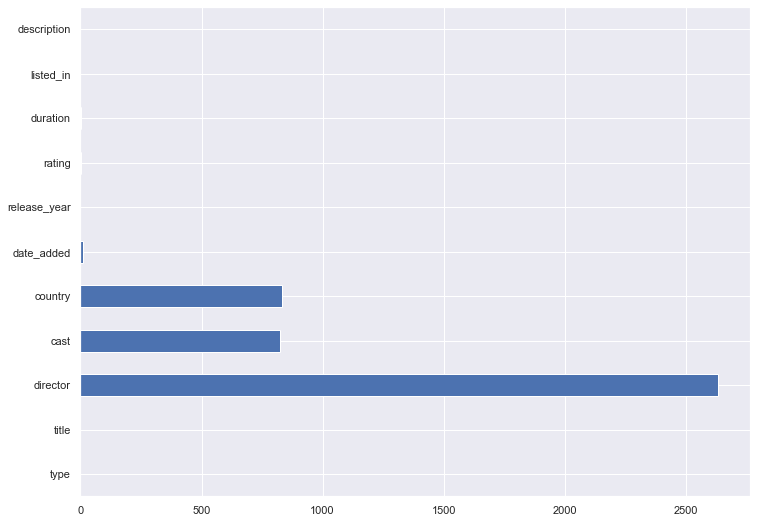

In [262]:
netflix.isna().sum().plot.barh()


Do any pairs of missing values appear together more often than with others?

<AxesSubplot:>

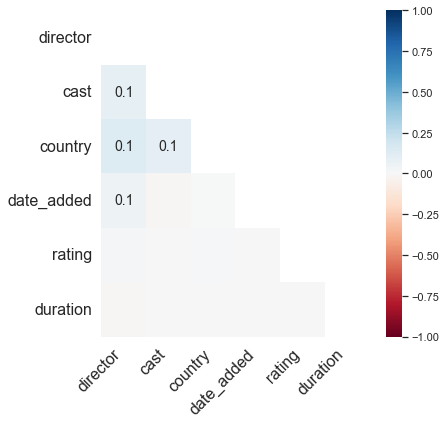

In [263]:
msno.heatmap(netflix, figsize=(6, 6))


It seems not. The large number of missing directors look to be randomly distributed (or caused by some variable not measured in this data).


# Analysis

### Movies vs Series

<AxesSubplot:ylabel='type'>

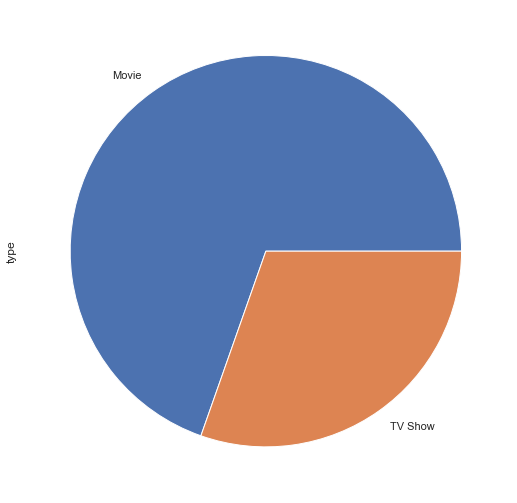

In [264]:
netflix['type'].value_counts().plot(kind='pie')


### Country

We see that some shows are produced by more than one country.


In [265]:
netflix['country'].value_counts().tail()


Romania, Bulgaria, Hungary                1
Uruguay, Guatemala                        1
France, Senegal, Belgium                  1
Mexico, United States, Spain, Colombia    1
United Arab Emirates, Jordan              1
Name: country, dtype: int64

This will be accounted for latter on, but for now, let's consider the shows produced by only one country.


In [266]:
one_country = netflix.loc[~netflix['country'].str.contains(',').fillna(True)]


In [267]:
one_country.shape

(6656, 11)

<AxesSubplot:>

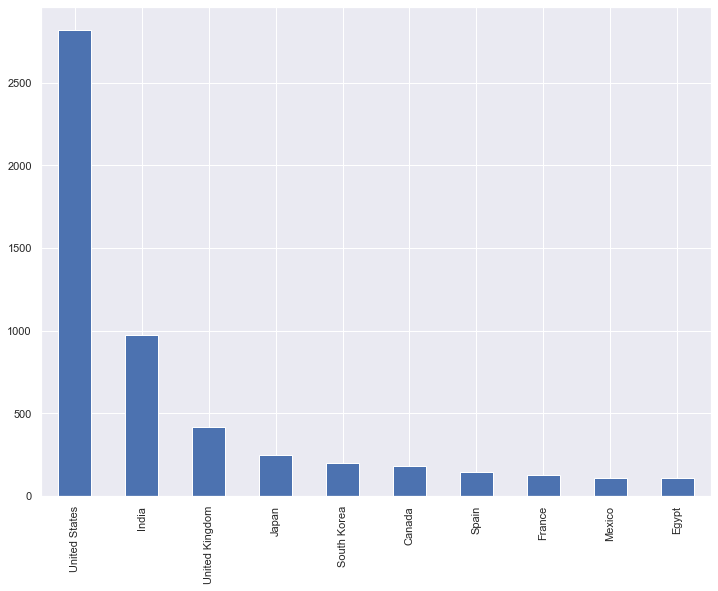

In [268]:
one_country['country']\
    .value_counts().head(10)\
    .plot(kind='bar')


### Type by Country

In [269]:
type_by_one_country = one_country.groupby('type')['country']\
    .value_counts().unstack(0)


<AxesSubplot:ylabel='country'>

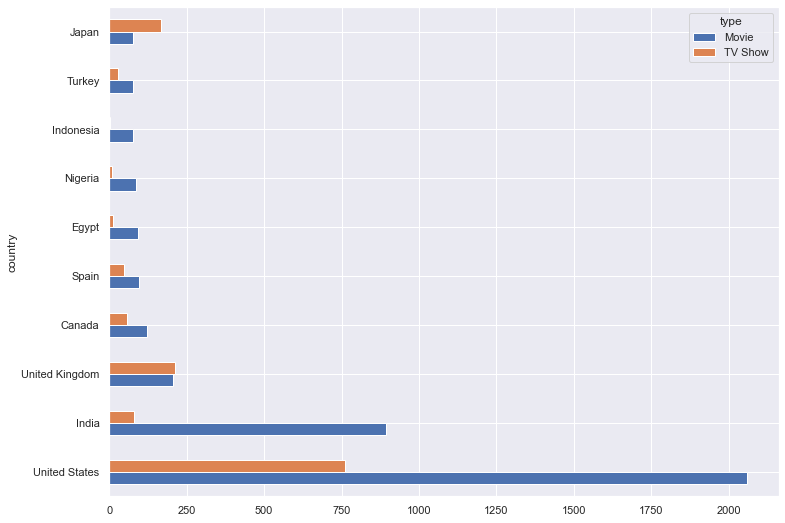

In [270]:
type_by_one_country.sort_values('Movie', ascending=False)\
    .head(10).plot(kind='barh')


<AxesSubplot:ylabel='country'>

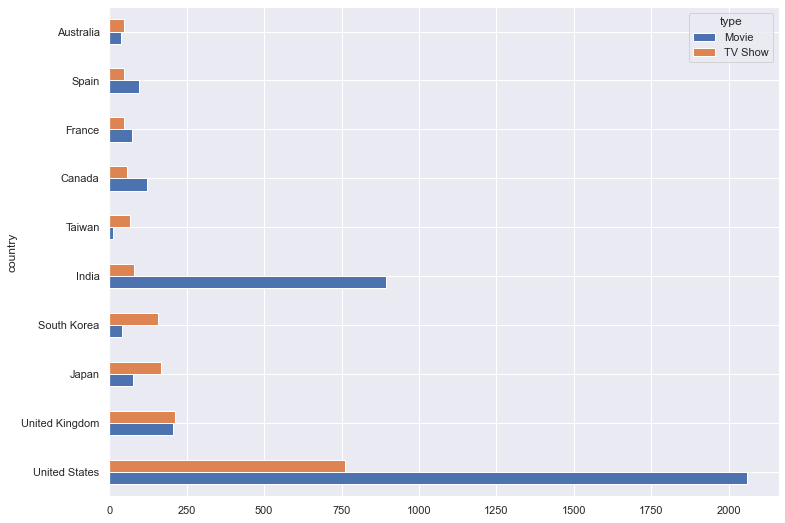

In [271]:
type_by_one_country.sort_values('TV Show', ascending=False)\
    .head(10).plot(kind='barh')


### Date Added

We group the `date_added` column into bins of size 2 months.

<AxesSubplot:xlabel='date_added'>

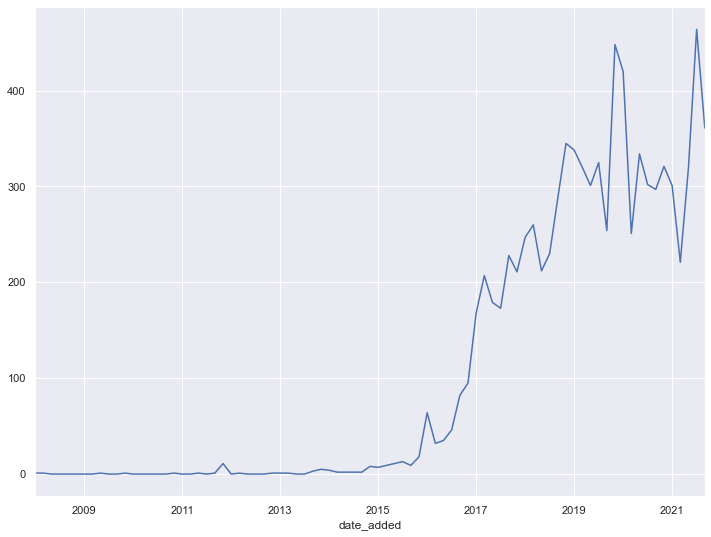

In [272]:
netflix.set_index('date_added')\
    .groupby(pd.Grouper(freq='2M'))['title']\
    .count().plot()


### Release Year

<AxesSubplot:>

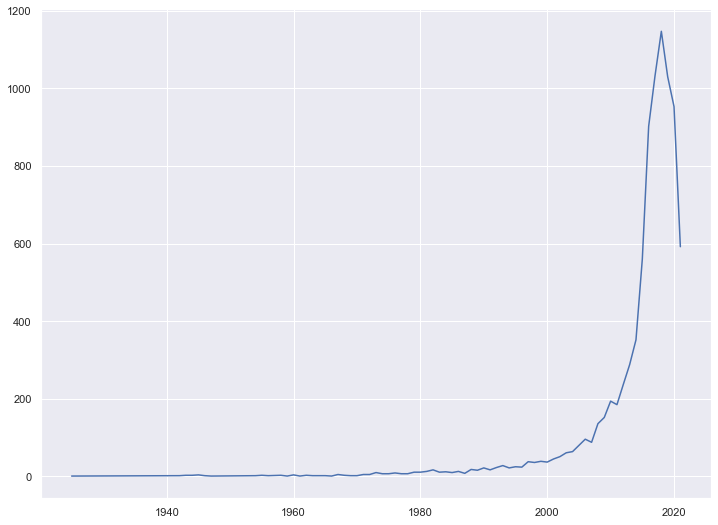

In [273]:
netflix['release_year']\
    .value_counts().sort_index()\
    .plot()


### Date Added vs Release Year

In [274]:
release_vs_added = pd.DataFrame([netflix['release_year'],
                                 netflix['date_added'].dt.year]).T

release_vs_added.head()


,release_year,date_added
show_id,,
s1,2020.0,2021.0
s2,2021.0,2021.0
s3,2021.0,2021.0
s4,2021.0,2021.0
s5,2021.0,2021.0


Items are added 4.7 years after their release, on average.


In [275]:
release_vs_added.diff(axis=1)['date_added'].describe()


count    8797.000000
mean        4.688417
std         8.786998
min        -3.000000
25%         0.000000
50%         1.000000
75%         5.000000
max        93.000000
Name: date_added, dtype: float64

The negative `min` tells us that some shows were added to Netflix before they were released. Let's see which ones.


In [276]:
added_before_release = release_vs_added[release_vs_added['release_year']
                                        > release_vs_added['date_added']]


In [277]:
added_before_release.merge(netflix, on='show_id')[
    ['title', 'release_year_x', 'date_added_x']]


,title,release_year_x,date_added_x
show_id,,,
s1552,Hilda,2021.0,2020.0
s1697,Polly Pocket,2021.0,2020.0
s2921,Love Is Blind,2021.0,2020.0
s3169,Fuller House,2020.0,2019.0
s3288,Maradona in Mexico,2020.0,2019.0
s3370,BoJack Horseman,2020.0,2019.0
s3434,The Hook Up Plan,2020.0,2019.0
s4845,Unbreakable Kimmy Schmidt,2019.0,2018.0
s4846,Arrested Development,2019.0,2018.0


### Rating

First, we impose a categorical ordering to the ratings.
We'll start by checking which ratings are possible


In [278]:
netflix['rating'].value_counts()


TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: rating, dtype: int64

In [279]:
rating_order = ['TV-Y', 'TV-Y7', 'TV-Y7-FV', 'TV-G', 'G',
                'TV-PG', 'PG', 'PG-13', 'TV-14', 'NC-17', 'R',  'TV-MA', 'NR', 'UR']


Some records have been given incorrect ratings (`74 min`, for example). Let's set those as `NA`.


In [280]:
netflix['rating'] = netflix['rating']\
    .apply(lambda x: x if x in rating_order else np.nan)


In [281]:
netflix['rating'].value_counts()


TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
Name: rating, dtype: int64

Change the type to `category`

In [282]:
netflix['rating'] = netflix['rating'].astype('category')
netflix['rating'] = netflix['rating'].cat.reorder_categories(rating_order)


<AxesSubplot:>

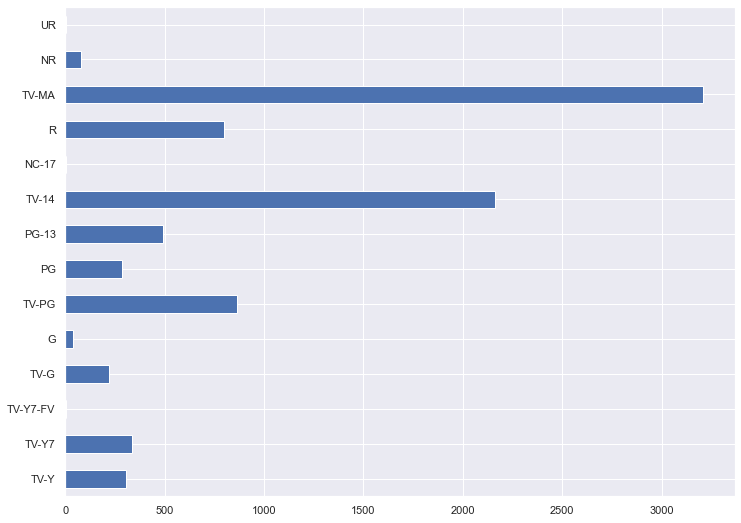

In [283]:
netflix['rating']\
    .value_counts().sort_index()\
    .plot(kind='barh')


### Ratings by Type

Only the ratings which apply to both types are considered here


In [284]:
ratings_both = ['TV-Y', 'TV-Y7', 'TV-G', 'TV-PG', 'TV-14', 'TV-MA']


<AxesSubplot:>

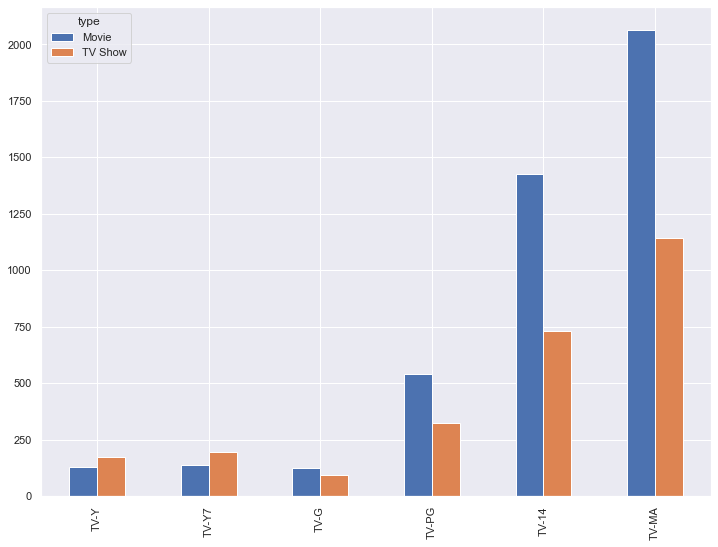

In [285]:
netflix.groupby('type')['rating']\
    .value_counts().unstack(0)\
    .loc[ratings_both]\
    .plot(kind='bar')


### Duration

In [286]:
movies = netflix.loc[netflix['type'] == 'Movie']
tv_shows = netflix.loc[netflix['type'] == 'TV Show']


We need to extract the integer value of the duration from the string.

Either `seasons` for TV Shows, or `duration` in minutes for Movies


In [287]:
movies['duration_int'] = movies.loc[:, 'duration']\
    .str.extract('(\d+)').astype(float)

tv_shows['seasons'] = tv_shows.loc[:, 'duration']\
    .str.extract('(\d+)').astype(int)


C:\Users\rossk\AppData\Local\Temp\ipykernel_6808\2974617886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['duration_int'] = movies.loc[:, 'duration']\
C:\Users\rossk\AppData\Local\Temp\ipykernel_6808\2974617886.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tv_shows['seasons'] = tv_shows.loc[:, 'duration']\


In [288]:
movies['duration_int'].describe()


count    6128.000000
mean       99.577187
std        28.290593
min         3.000000
25%        87.000000
50%        98.000000
75%       114.000000
max       312.000000
Name: duration_int, dtype: float64

The five longest movies


In [289]:
movies.sort_values('duration_int', ascending=False)[
    ['title', 'duration_int']].head(5)


,title,duration_int
show_id,,
s4254,Black Mirror: Bandersnatch,312.0
s718,Headspace: Unwind Your Mind,273.0
s2492,The School of Mischief,253.0
s2488,No Longer kids,237.0
s2485,Lock Your Girls In,233.0


In [290]:
tv_shows['seasons'].describe()


count    2676.000000
mean        1.764948
std         1.582752
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        17.000000
Name: seasons, dtype: float64

And the five longest running TV shows

In [291]:
tv_shows.sort_values('seasons', ascending=False)[
    ['title', 'seasons']].head(5)


,title,seasons
show_id,,
s549,Grey's Anatomy,17
s2424,Supernatural,15
s4799,NCIS,15
s1355,Heartland,13
s4221,COMEDIANS of the world,13


### Rating vs Duration

Movies get longer for older audiences


<AxesSubplot:xlabel='rating', ylabel='duration_int'>

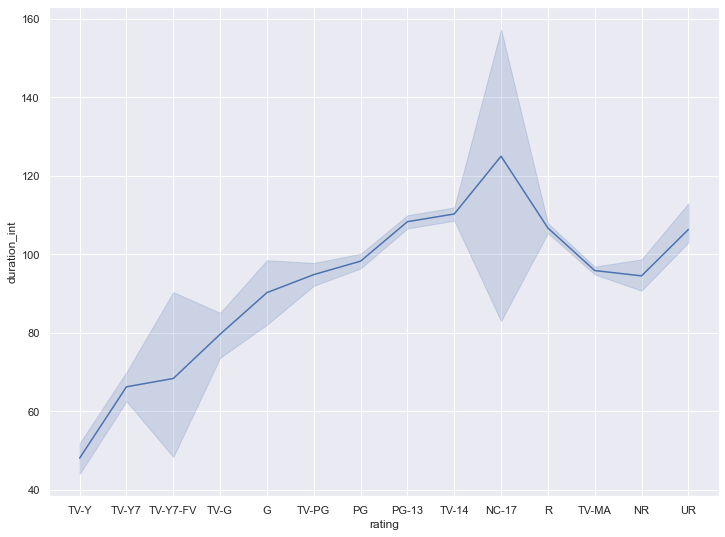

In [292]:
sns.lineplot(data=movies, x='rating', y='duration_int')


Series tend to have a similar number of seasons regardless of the age of the target audience


<AxesSubplot:xlabel='rating', ylabel='seasons'>

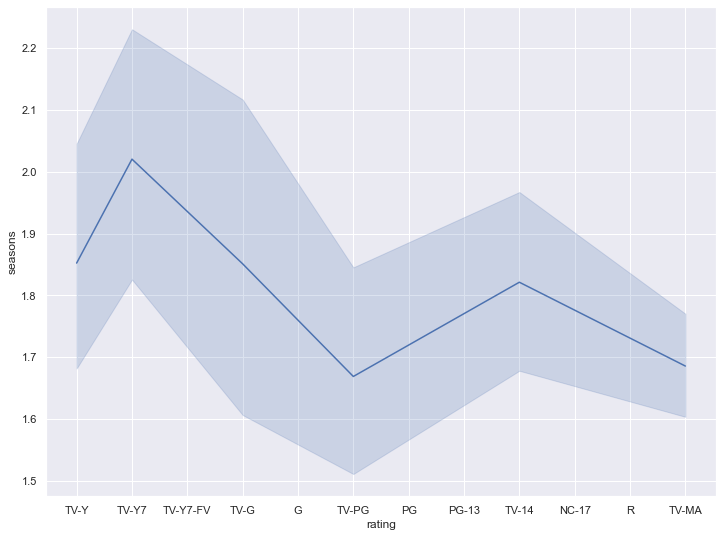

In [293]:
sns.lineplot(data=tv_shows[tv_shows['rating'].isin(ratings_both)],
             x='rating', y='seasons')


### Duration vs Release Year

<AxesSubplot:xlabel='release_year', ylabel='duration_int'>

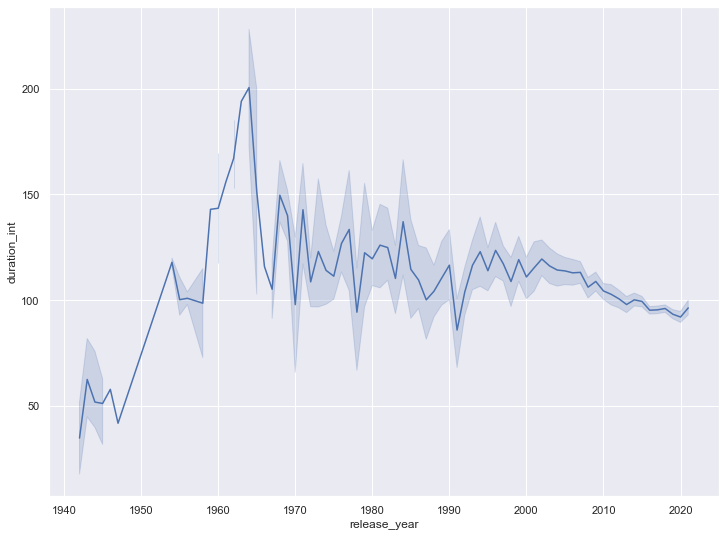

In [294]:
sns.lineplot(data=movies, x='release_year', y='duration_int')


The same data grouped into 5 year bins

<AxesSubplot:xlabel='release_year'>

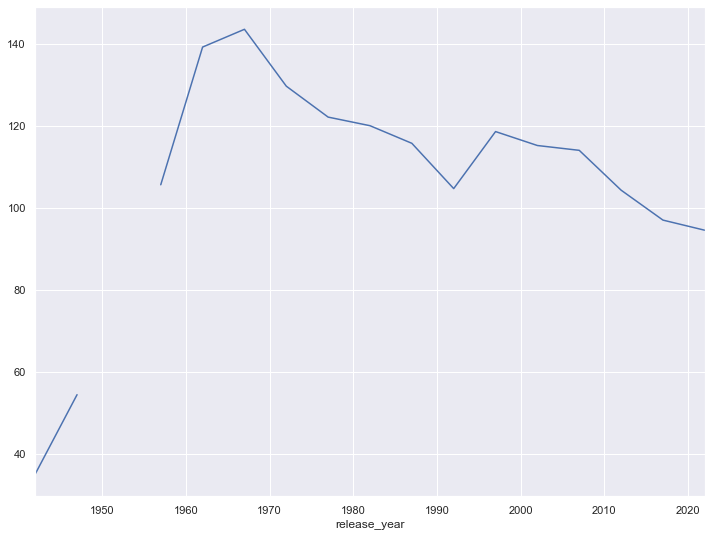

In [295]:
release_year_index = pd.to_datetime(movies['release_year'], format='%Y')

movies.set_index(release_year_index)\
    .groupby(pd.Grouper(freq='5A'))['duration_int'].mean()\
    .plot()


## Unwrap Multi-Response Columns

Some columns represent multiple values, such as `listed_in`, which is a comma-separated list of genre types for each item.

To fully analyse these variables, let's unwrap them into multiple binary columns


In [296]:
unwrapped = netflix.copy()


In [297]:
def split_multiresponse(multi: str):
    """
    Split a string into a list of strings, separated by commas.

    Being sure to check for missing values.
    """
    return [s.strip() for s in (multi.split(', ') if type(multi) == str else '')]


In [298]:
all_cats = []
for cats in unwrapped['listed_in']:
    for cat in split_multiresponse(cats):
        all_cats.append(cat)

all_cats = pd.Series(all_cats).unique()


all_countries = []
for countries in unwrapped['country']:
    for country in split_multiresponse(countries):
        all_countries.append(country)

all_countries = pd.Series(all_countries).unique()


In [299]:
cat_frame = pd.concat([
    unwrapped['listed_in']
    .apply(lambda x: 1 if cat in split_multiresponse(x) else 0)
    for cat in all_cats
], keys=['cat_' + cat for cat in all_cats], axis=1)

unwrapped = pd.concat([unwrapped, cat_frame], axis=1)


In [300]:
cnt_frame = pd.concat([
    unwrapped['country']
    .apply(lambda x: 1 if country in split_multiresponse(x) else 0)
    for country in all_countries
], keys=['cnt_' + country for country in all_countries], axis=1)

unwrapped = pd.concat([unwrapped, cnt_frame], axis=1)


In [301]:
def colStart(start: str):
    """Return all columns in `unwrapped` that start with `start`."""
    cols = unwrapped.columns
    return [c for c in cols if c.startswith(start)]


Now, let's investigate


### Most Popular Categories/Genres


<AxesSubplot:>

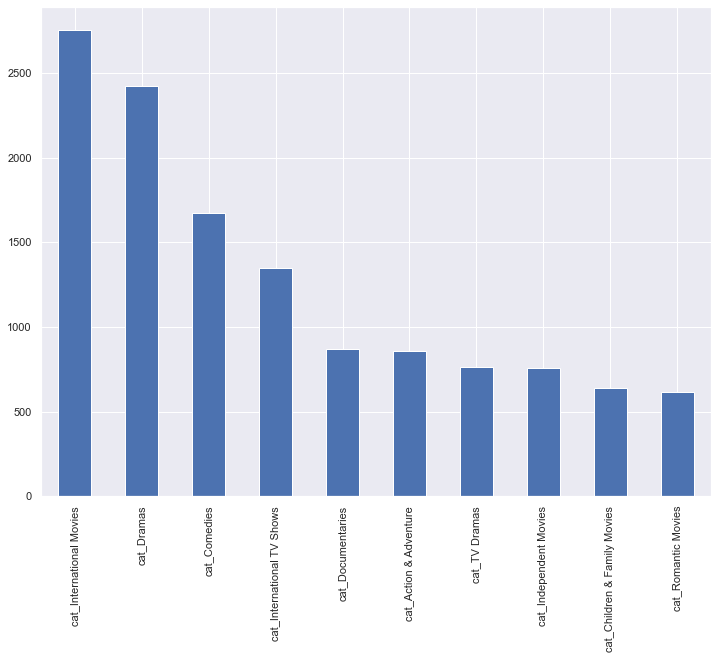

In [302]:
unwrapped[colStart('cat_')].sum()\
    .sort_values(ascending=False).head(10)\
    .plot(kind='bar')


### Most Popular Countries

<AxesSubplot:>

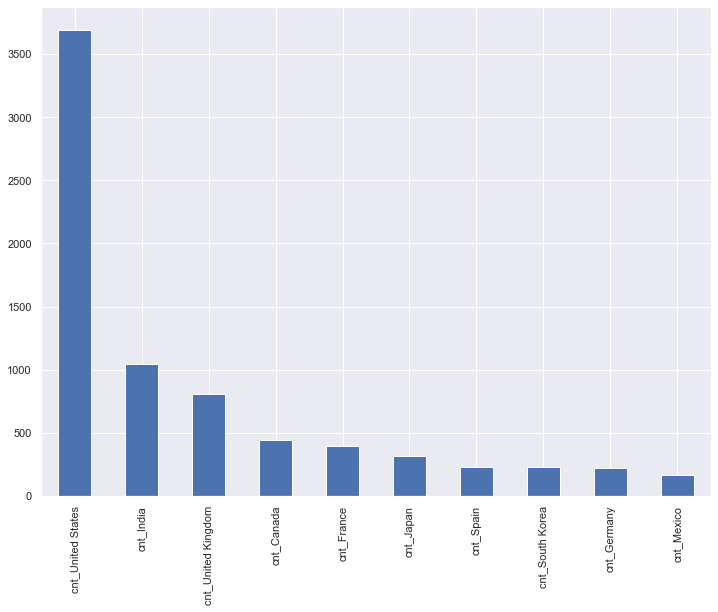

In [303]:
unwrapped[colStart('cnt_')].sum()\
    .sort_values(ascending=False).head(10)\
    .plot(kind='bar')


### Rating vs Genre

In [304]:
cats = colStart('cat_')

rating_by_cat = pd.concat([
    unwrapped.groupby('rating')[cat]
    .value_counts().loc[:, 1]
    for cat in cats
], axis=1, keys=[c.split('cat_')[-1] for c in cats])\
    .fillna(0)\
    .sort_index()


Almost all Stand-up comedy shows are rated `TV-MA`

<AxesSubplot:ylabel='rating'>

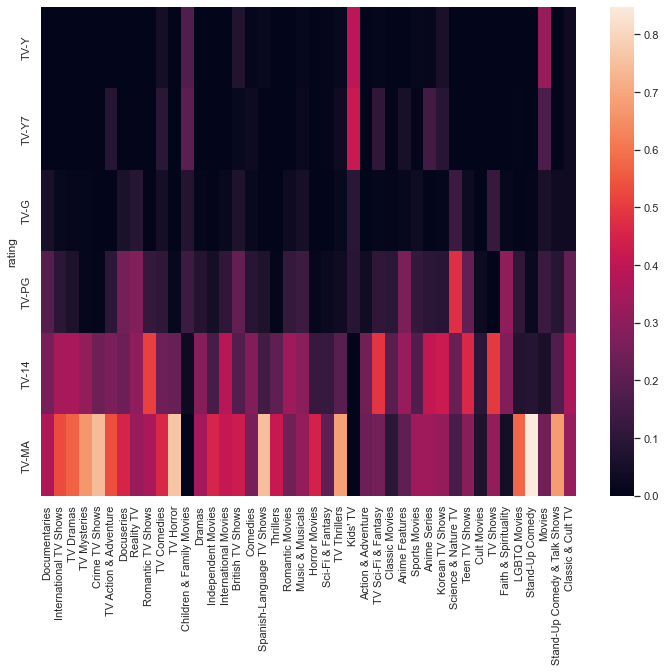

In [308]:
sns.heatmap((rating_by_cat / rating_by_cat.sum())
            .loc[ratings_both])


### Rating vs Country


In [311]:
cols = colStart('cnt_')

rating_by_country = pd.concat([
    unwrapped.groupby('rating')[col]
    .value_counts().loc[:, 1]
    for col in cols
], axis=1, keys=[c.split('cnt_')[-1] for c in cols])\
    .fillna(0)\
    .loc[:, one_country['country'].value_counts().head(20).index]


<AxesSubplot:ylabel='rating'>

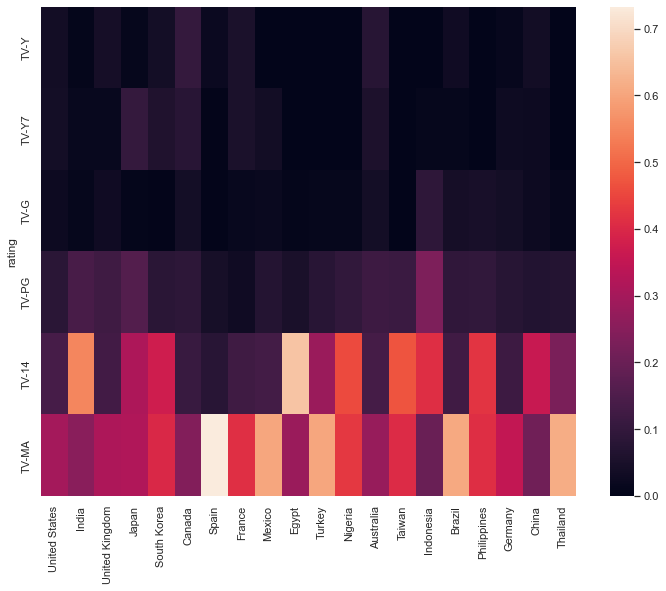

In [312]:
sns.heatmap((rating_by_country / rating_by_country.sum())
            .loc[ratings_both])
